#  Predicting Property Value and Crime Rate

The purpose of this model is to predict crime based on propery types of the area. To do this I pulled crime data from Sandy Springs, GA police department. To be fair about the analysis I removed traffic crime from the data set to remove any possible skewing from vehicular based crimes. I then classified the types of crime into two catagories, violent and nonviolent crimes. I did this in a hope to help determine any correlations that may exist regarding crime and property types. After cleaning the data and removing years prior to 2009, which appeared to be incorrectly entered or pilot data from 2008, I ended up with just under 55,000 records.

To pull the property value data so I could classify them later to types I turned to the county tax records for the record of property sales. I pulled the data for the last year which provided about 48000 records. This proved to be less fruitful, after cleaning the retrieved 48,000 records and removing records not pertaining to Sandy Springs, I was left with just over 2000 data points. To help improve these numbers I turned to web scraping an apartment site, rentjungle.com. This provided an additional 200 locations to the to compare with. I then categorized the data as shown below. 

    House price less than or equal to 300001: Low
    House price less than or equal to 600001: Average
    House price less than or equal to 900001: Above Average
    House price Over 900001                 : High
    Apartment data was left as              : Apartment
 
With these now classified I combined the property and apartment data sets. I the ran them through KNN with the combined set initially alone as a 75/25 test train split. Once I had those results I then ran the combined house/apartment data set as the training data and the test set as the crime data. Doing this would allow a value to be assigned to the crime data. This was done in relation to the Latitudes and Longitudes of each property, apartment, and crime committed. 

The results found were as listed below:


   KNN with 3 Neighbors - 77.68%

        Crime estimation with KNN 3 
        Apartment        27023
        Low              12285
        Average           8905
        Above Average     4927
        High              1633

        Percentage of Crime with KNN 3 
        Apartment        49.33%
        Low              22.42%
        Average          16.25%
        Above Average     9.00%
        High              3.00%
    
   KNN with 1 Neighbor - 93.19%

        Crime estimation with KNN 1 
        Apartment        26812
        Low              12916
        Average           9482
        High              3240
        Above Average     2323
    
        Percentage of Crime with KNN 1 
        Apartment        48.95%
        Low              23.58%
        Average          17.31%
        High              5.92%
        Above Average     4.24%
    
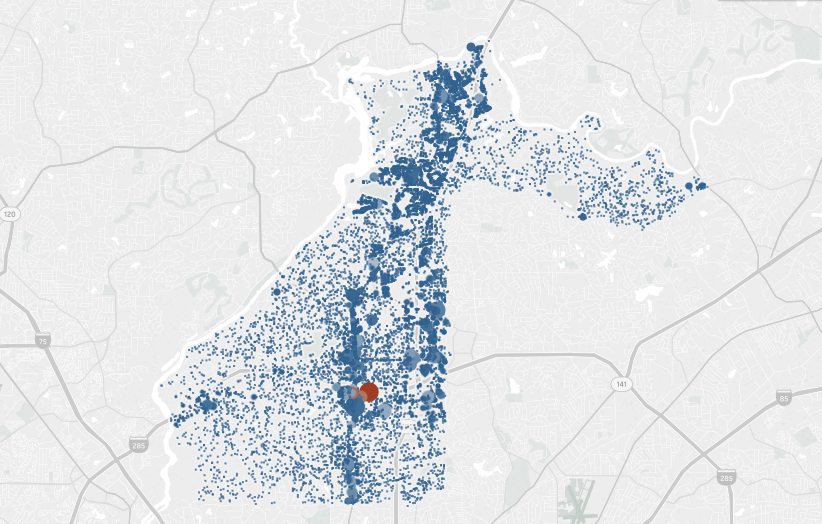
    
Though I was not able to find a direct correlation in the data I had, there was clearly a correlation between low house values and apartments with regards to crime. When plotted in Tableau it was clear that this was true along with another underlying factor that would take further efforts, this was the proximity of a major road. Proximity to a major road appeared to show significantly more crime than areas further away. 

For reach items I would like to obtain more property information to further prove my point and possibly data from another city to see if the model hold true. I would also like to dig in deeper to the hidden item of the proximity to a major road and see if that was a common thread or just a one off this data created.

In [192]:
import pandas as pd
import sklearn as sms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import random
import requests
import calendar

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from time import sleep
from datetime import date
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup

geolocator = Nominatim()

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Crime Data
### EXPLORE THE DATA: 
##### Crime data was extracted from Sandy Springs Pubic Crime Records

In [4]:
crime = pd.read_csv('C:\Users\Dracofire013\Desktop\dsi-atl-3\Cap_Stone\Sandy_Springs_Police_Department.csv')
crime.shape

C:\Users\Dracofire013\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(75489, 21)

In [5]:
crime.parent_incident_type.unique()

array(['Traffic', 'Property Crime', 'Family Offense', 'Theft', 'Other',
       'Theft from Vehicle', 'Assault with Deadly Weapon',
       'Breaking & Entering', 'Assault', 'Disorder', 'Theft of Vehicle',
       'Weapons Offense', 'Drugs', 'Missing Person', 'Robbery',
       'Property Crime Commercial', 'Arson', 'Vehicle Recovery', 'Liquor',
       'Homicide'], dtype=object)

### CLEANING THE DATA STEPS:
#### Cluster the crimes by types (Violent or Non-Violent)

In [6]:
crime['Crime Type'] = crime['parent_incident_type']
violent = ['Assault with Deadly Weapon','Assault','Weapons Offense','Robbery','Homicide']

for i in violent:
    crime['Crime Type'] = crime['Crime Type'].str.replace(i,'Violent')
    
crime['Crime Type'] = ['Violent' if x == 'Violent' else 'Non-Violent' for x in crime['Crime Type']]

#### Convert the previous incident_datetime to useable dates and time fields then create time clusters for analysis

In [7]:
crime['incident_datetime'] = pd.to_datetime(crime['incident_datetime'])

In [8]:
crime['year_committed'] = pd.DatetimeIndex(crime['incident_datetime']).year
crime['month_committed'] = pd.DatetimeIndex(crime['incident_datetime']).month
crime['day_committed'] = pd.DatetimeIndex(crime['incident_datetime']).day
crime['hour_committed'] = pd.DatetimeIndex(crime['incident_datetime']).hour
crime['time_block'] = pd.DatetimeIndex(crime['incident_datetime']).hour

In [9]:
time_block = []
for i in crime.hour_committed:
    if crime.hour_committed[i] >= 18:
        time_block.append(4)
    elif crime.hour_committed[i] >= 12:
        time_block.append(3)
    elif crime.hour_committed[i] >= 6:
        time_block.append(2)
    else:
        time_block.append(1)

In [10]:
crime.time_block = time_block

#### Remove all unnecessary columns and dates that may have been incorrectly entered

In [11]:
crime_columns_removal = ['clearance_type','address_2','country','city','state','updated_at','incident_datetime',
                        'created_at','zip','incident_datetime','incident_type_primary','hour_of_day','incident_description',
                        'incident_id']

for i in crime_columns_removal:
    try:
        crime = crime.drop([i], axis=1,inplace=False)
    except:
        pass

In [12]:
crime = crime[crime.parent_incident_type != 'Traffic']
crime = crime[crime.parent_incident_type != 'Vehicle Recovery']

In [13]:
crime = crime[crime['year_committed'] > 2008] 

#### Reset the Indexes and Save the Data

In [14]:
crime = crime.reset_index(drop=True)

In [15]:
crime.to_csv('Crime_Data.csv', encoding='utf-8')

#### Create a Test/Train split to run through KNN and save the datasets to file

In [16]:
train_crime = crime[:int((len(crime)+1)*.80)] #Splits 80% to training set
train_crime.to_csv('Train_Crime_Data.csv', encoding='utf-8')
test_crime = crime[int(len(crime)*.80+1):] #Splits 20% data to test set
test_crime.to_csv('Test_Crime_Data.csv', encoding='utf-8')

## City of Atlanta Crime Data

In [153]:
atlanta_crime_2009 = pd.read_csv('C:\Users\Dracofire013\Desktop\dsi-atl-3\Capstone\COBRA-YTD2009-Query.csv')
atlanta_crime_2010 = pd.read_csv('C:\Users\Dracofire013\Desktop\dsi-atl-3\Capstone\COBRA-YTD2010-Query.csv')
atlanta_crime_2011 = pd.read_csv('C:\Users\Dracofire013\Desktop\dsi-atl-3\Capstone\COBRA-YTD2011-Query.csv')
atlanta_crime_2012 = pd.read_csv('C:\Users\Dracofire013\Desktop\dsi-atl-3\Capstone\COBRA-YTD2012-Query.csv')
atlanta_crime_2013 = pd.read_csv('C:\Users\Dracofire013\Desktop\dsi-atl-3\Capstone\COBRA-YTD2013-Query.csv')
atlanta_crime_2014 = pd.read_csv('C:\Users\Dracofire013\Desktop\dsi-atl-3\Capstone\COBRA-YTD2014-Query.csv')
atlanta_crime_2015 = pd.read_csv('C:\Users\Dracofire013\Desktop\dsi-atl-3\Capstone\COBRA-YTD2015-Query.csv')
atlanta_crime_2016 = pd.read_csv('C:\Users\Dracofire013\Desktop\dsi-atl-3\Capstone\COBRA-YTD2016-Query.csv')
atlanta_crime_2017 = pd.read_csv('C:\Users\Dracofire013\Desktop\dsi-atl-3\Capstone\COBRA-YTD2017-Query.csv')

In [154]:
crime_ATL = pd.concat([atlanta_crime_2009,atlanta_crime_2010,atlanta_crime_2011,atlanta_crime_2012,atlanta_crime_2013,
                           atlanta_crime_2014,atlanta_crime_2015,atlanta_crime_2016,atlanta_crime_2017])

In [188]:
crime_ATL.shape

(279214, 28)

In [164]:
crime_ATL['occur_date'] = pd.to_datetime(crime_ATL['occur_date'])
crime_ATL['year_committed'] = pd.DatetimeIndex(crime_ATL['occur_date']).year
crime_ATL['month_committed'] = pd.DatetimeIndex(crime_ATL['occur_date']).month
crime_ATL['day_committed'] = pd.DatetimeIndex(crime_ATL['occur_date']).day
crime_ATL['weekday_committed'] = pd.DatetimeIndex(crime_ATL['occur_date']).weekday

In [168]:
crime_ATL['weekday_committed'] = crime_ATL['weekday_committed'].replace([0], 'Monday')
crime_ATL['weekday_committed'] = crime_ATL['weekday_committed'].replace([1], 'Tuesday')
crime_ATL['weekday_committed'] = crime_ATL['weekday_committed'].replace([2], 'Wednesday')
crime_ATL['weekday_committed'] = crime_ATL['weekday_committed'].replace([3], 'Thurday')
crime_ATL['weekday_committed'] = crime_ATL['weekday_committed'].replace([4], 'Friday')
crime_ATL['weekday_committed'] = crime_ATL['weekday_committed'].replace([5], 'Saturday')
crime_ATL['weekday_committed'] = crime_ATL['weekday_committed'].replace([6], 'Sunday')

In [182]:
crime_ATL = crime_ATL[crime_ATL['year_committed'] > 2008] 

In [183]:
print pd.value_counts(crime_ATL['UC2 Literal'].values, sort=True)

LARCENY-FROM VEHICLE    80472
LARCENY-NON VEHICLE     66854
BURGLARY-RESIDENCE      43693
AUTO THEFT              39152
AGG ASSAULT             19876
ROBBERY-PEDESTRIAN      14809
BURGLARY-NONRES          8750
ROBBERY-RESIDENCE        1928
ROBBERY-COMMERCIAL       1892
RAPE                     1042
HOMICIDE                  746
dtype: int64


In [194]:
crime_ATL['Crime Type'] = crime_ATL['UC2 Literal']
violent = ['AGG ASSAULT','ROBBERY-PEDESTRIAN','ROBBERY-RESIDENCE','ROBBERY-COMMERCIAL','RAPE','HOMICIDE']

for i in violent:
    crime_ATL['Crime Type'] = crime_ATL['Crime Type'].str.replace(i,'Violent')
    
crime_ATL['Crime Type'] = ['Violent' if x == 'Violent' else 'Non-Violent' for x in crime_ATL['Crime Type']]

C:\Users\Dracofire013\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Dracofire013\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Dracofire013\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [130]:
crime_ATL.to_csv('Atlanta_Crime.csv', encoding='utf-8', mode='w', header=True)

# Property Data
### EXPLORE THE DATA:
##### Property data was extracted from Fulton County Public Tax Record of Sales

In [202]:
property_prices = pd.read_csv('C:/Users/Dracofire013/Desktop/dsi-atl-3/Cap_Stone/Property_Sales/Fulton_County_Sales_2016.csv')

In [203]:
property_prices.shape

(49788, 24)

In [204]:
property_prices.head(2)

,Parcel Number,Owner Name,Grantor,Grantee,Zoning,Property Type,District,Sale Date,Sale Price,Living Area,...,Neighborhood,Sales Validity,OWNER1,OWNER2,ADDRESS1,ADDRESS2,ADDRESS3,CITY,STATE,ZIP
0,14 019400010683,LANUZA GABRIEL & ESPINOZA MARTHA,GOMEZ EFRAIN,LANUZA GABRIEL &,R1-,R3,20,2016-01-31,NaN,1053,...,NaN,Deed of Gift,LANUZA GABRIEL &,ESPINOZA MARTHA,2674 BEN HILL AVE,NaN,NaN,ATLANTA,GA,30334
1,12 280107690367,SCHLICHTING RANDALL J & SCHLICHTING DOROTHY B,WOOD LEWIS KEITH,WOOD CYNTHIA LYNN,CUP-,R3,45,2016-01-31,NaN,1729,...,NaN,Sale < = 1000,SCHLICHTING RANDALL J &,SCHLICHTING DOROTHY B,421 SASSAFRAS RD,NaN,NaN,ROSWELL,GA,30076


### CLEANING THE DATA STEPS:
#### Remove cash signs and commas from the price and convert numbers to floats

In [205]:
try:
    property_prices['Sale Price'] = property_prices['Sale Price'].str.replace('$', '')
except:
    pass
try:
    property_prices['Sale Price'] = property_prices['Sale Price'].str.replace(',', '')
except:
    pass

change_to_float = ['Sale Price','District','Living Area','Year Built','District']
for i in change_to_float:
    try:
        property_prices[i] = pd.to_numeric(property_prices[i], errors='coerce')
    except:
        pass

#### Remove bad and distorting data

In [206]:
property_prices = property_prices[property_prices['Sales Validity'] != 'Sale Includes Multiple Parcels']
property_prices = property_prices[property_prices['Sales Validity'] != 'Sale < = 1000']
property_prices = property_prices.dropna(subset=['Sale Price'])
property_prices = property_prices[property_prices['Sale Price'] > 20000]
property_prices = property_prices[property_prices['STATE'] == 'GA']

#### Remove unnessesary columns and remaining NaN values

In [207]:
remove_columns = ['ADDRESS2', 'ADDRESS3','Neighborhood','Zoning','OWNER2','Sale Date','Grantee','Sale Qual','Sales Validity',
                 'OWNER1','Owner Name','STATE','Grantor']
for i in remove_columns:
    try:
        property_prices = property_prices.drop([i], axis=1,inplace=False)
    except:
        pass

In [208]:
property_prices = property_prices.dropna()

In [209]:
property_prices = property_prices.sort_values(['Sale Price'], ascending=[False])

In [210]:
property_prices = property_prices.drop_duplicates().reset_index(drop=True)

#### Filter the zip codes for property in Sandy Springs or Leave for all of Fulton County

In [212]:
property_prices['ZIP'] = property_prices['ZIP'].str.extract('(.....)', expand=True)

In [35]:
# zips = {'30319','30327','30328','30338','30339','30342','30350'}

# property_prices = property_prices[property_prices.ZIP.isin(zips)]

In [213]:
property_prices = property_prices.reset_index(drop=True)

#### Setting a Property Type for KNN and add it to the DataFrame

In [231]:
property_prices['Sale Price'].mean()
property_type = []
for i in property_prices['Sale Price']:
    if i <= 300001.0:
        property_type.append('Low')
    elif i <= 600001.0:
        property_type.append('Average')
    elif i <= 900001.0:
        property_type.append('Above Average')
    else:
        property_type.append('High')

In [232]:
property_prices['property_type'] = property_type

#### Remove Data that will not return a GEO Code and prep the data to be ran through GEO Code Tool

In [216]:
property_prices['ADDRESS1'] = property_prices['ADDRESS1'].apply(lambda x: x.split(' UNIT')[0])
property_prices['ADDRESS1'] = property_prices['ADDRESS1'].apply(lambda x: x.split(' #')[0])
property_prices['ADDRESS1'] = property_prices['ADDRESS1'].apply(lambda x: x.split(' SUITE')[0])
property_prices['ADDRESS1'] = property_prices['ADDRESS1'].apply(lambda x: x.split(' APT')[0])
property_prices['ADDRESS1'] = property_prices['ADDRESS1'].apply(lambda x: x.split(' STE')[0])
property_prices['ADDRESS1'] = property_prices['ADDRESS1'].apply(lambda x: x.split('/STE')[0])

In [217]:
property_prices = property_prices.reset_index(drop=True)
property_prices = property_prices.drop_duplicates(['ADDRESS1'])

In [218]:
property_prices['Addresses'] = property_prices['ADDRESS1'].str.cat(property_prices['ZIP'].values.astype(str), sep=',')

#### Use the GEO Code Tool to pull the Latitude and Longitude of the properties

In [221]:
# Sandy Springs Data
# property_data = pd.read_csv('C:\Users\Dracofire013\Desktop\dsi-atl-3\Capstone\property_data.csv',index_col=[False])
# property_prices = pd.read_csv('C:\Users\Dracofire013\Desktop\dsi-atl-3\Capstone\Property_Prices.csv',index_col=[False])

# Atlanta Data
# property_data = pd.read_csv('C:\Users\Dracofire013\Desktop\dsi-atl-3\Capstone\property_data_Altanta.csv',index_col=[False])
# property_prices = pd.read_csv('C:\Users\Dracofire013\Desktop\dsi-atl-3\Capstone\Property_Prices_Altanta.csv',index_col=[False])

In [275]:
# Adding the Lat and Long for each address
lat_long = []
places = []
count = 0
for i in property_prices.Addresses:
    count +=1
    print count
    print i
    sleep(1)
    try:
        location = geolocator.geocode(i)
        lat_long.append(location)
        places.append(i)
    except:
        lat_long.append(i)
        places.append(i)

1
3344 PEACHTREE RD NE,30326
2
3340 PEACHTREE RD,30326
3
3414 PEACHTREE RD NE,30326
4
793 SAWYER RD,30062
5
400 GALLERIA PKWY SE,30339


KeyboardInterrupt: 

In [276]:
property_clean

,Parcel Number,Property Type,District,Sale Price,Living Area,Acres,Year Built,Location Address,ADDRESS1,CITY,ZIP,property_type,Addresses,Latitudes,Longitudes
0,17 0210 LL0340,C5,59.0,80700000.0,405105.0,24.9000,1984.0,1600 RIVEREDGE PKWY,3344 PEACHTREE RD NE,ATLANTA,30326,High,"3344 PEACHTREE RD NE,30326",33.850486,-84.362109
1,17 006900050221,C5,59.0,69500000.0,574409.0,17.5000,1990.0,5501 GLENRIDGE DR,3340 PEACHTREE RD,ATLANTA,30326,High,"3340 PEACHTREE RD,30326",33.846986,-84.371905
2,11 025001210263,C5,10.0,65500000.0,216296.0,37.3000,2000.0,15000 PARKVIEW LN,3414 PEACHTREE RD NE,ATLANTA,30326,High,"3414 PEACHTREE RD NE,30326",33.850486,-84.362109
3,14 004700091617,C4,5.0,65338708.0,39446.0,2.7420,1974.0,345 BOULEVARD,793 SAWYER RD,MARIETTA,30062,High,"793 SAWYER RD,30062",33.982763,-84.525907
4,17 0005 LL0760,C4,5.0,55500000.0,439194.0,9.0000,2000.0,2124 CHESHIRE BRIDGE RD,400 GALLERIA PKWY SE,ATLANTA,30339,High,"400 GALLERIA PKWY SE,30339",33.883130,-84.465055
5,11 106003810357,C4,57.0,27000000.0,103628.0,7.9400,1999.0,6470 JOHNS CREEK CROSSING,1401 PEACHTREE ST,ATLANTA,30309,High,"1401 PEACHTREE ST,30309",33.793225,-84.386025
6,12 218005050490,C5,45.0,18060000.0,219890.0,14.3350,1985.0,555 EAGLE CROSSING VILLAGE LN,555 EAGLES CREST VILLAGE LANE,ROSWELL,30076,High,"555 EAGLES CREST VILLAGE LANE,30076",34.040956,-84.338507
7,17 023500020181,R5,5.0,17500000.0,26861.0,16.9930,2006.0,4110 PACES FERRY RD,2035 GARRAUX RD NW,ATLANTA,30327,High,"2035 GARRAUX RD NW,30327",33.856457,-84.454216
8,12 224005540779,I5,45.0,14050000.0,183216.0,15.0206,1988.0,11660 ALPHARETTA HWY,780 OLD ROSWELL PL,ROSWELL,30076,High,"780 OLD ROSWELL PL,30076",34.035643,-84.340663
9,17 006000010786,C4,5.0,13100000.0,0.0,2.0696,0.0,361 PHARR RD,3715 NORTHSIDE PKWY,ATLANTA,30327,High,"3715 NORTHSIDE PKWY,30327",33.856901,-84.429664


In [223]:
Latitudes_Houses  = []
Longitudes_Houses = []

for i in lat_long:
    location = i
    try:
        Latitudes_Houses.append(location.latitude)
        Longitudes_Houses.append(location.longitude)
    except:
        Latitudes_Houses.append(None)
        Longitudes_Houses.append(None)

In [224]:
property_prices['Latitudes'] = Latitudes_Houses
property_prices['Longitudes'] = Longitudes_Houses

In [225]:
property_clean = property_prices.dropna()

In [239]:
property_data = property_data.reset_index(drop=True)
property_clean = property_clean.reset_index(drop=True)
property_prices = property_prices.reset_index(drop=True)

In [233]:
# Create a DataFrame to store the informaiton
columns = ['Addresses', 'Latitudes', 'Longitudes','Property Type']
property_data = pd.DataFrame()
# Add the extracted data to the DataFrame
property_data['Addresses'] = property_clean.Addresses 
property_data['Latitudes'] = property_clean.Latitudes
property_data['Longitudes'] = property_clean.Longitudes
property_data['Property Type'] =2q property_clean.property_type

In [240]:
# property_data.to_csv('Property_Data.csv', encoding='utf-8', mode='w', header=True)
property_data.to_csv('Property_Data_Atlanta.csv', encoding='utf-8', mode='w', header=True)

In [241]:
# property_prices.to_csv('Property_Prices.csv', encoding='utf-8', mode='w', header=True)
property_prices.to_csv('Property_Prices_Atlanta.csv', encoding='utf-8', mode='w', header=True)

# Apartment Data
### EXPLORE THE DATA:
##### Apartment data was extracted from https://www.rentjungle.com/ to pull rental property locations in Sandy Springs, GA

C:\Users\Dracofire013\Desktop\dsi-atl-3\Cap_Stone\Rental Scraper.ipynb

#### The Webscraper

In [129]:
# apartments = []
# latitudes = []
# longitudes = []
# addresses = []

# for i in range(680):      # Number of pages plus one 
#     # Run for Sandy Springs Data
# #     url = 'https://www.rentjungle.com/sandy-springs-apartments-and-houses-for-rent/page:'+str(i+1)+'/house:2/' 
#     # Run for Atlanta Data
#     url = 'https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:'+str(i+1)+'/house:2/'
#     sleep(1) 
#     response = requests.get(url)
#     soup = BeautifulSoup(response.content)
    
#     # Printing the results to show it is going throug the pages properly
#     print url

#     # Definition that pulls all of the important data from each page
#     def find_appartment_names(soup_object):
        
#         # Pulls the apartment's name
#         for i in soup.findAll('h2',{'class':'listing'}):
#             apartment = i.text.strip()
#             apartments.append(apartment)

#         # Pulls the apartment's latitude
#         for i in soup.findAll(name='a', attrs={'list_marker'}):
#             output = i['onclick']
#             output = output[output.find("(")+1:output.find(")")]
#             latitude =  output.split(', ', 2)[1]
#             latitudes.append(latitude)
        
#         # Pulls the apartment's longitude
#             longitude = output.split(', ', 1)[-2]
#             longitudes.append(longitude)
        
#         # Pulls the apartment's address
#         for i in soup.findAll(name='h3'):
#             address = i.text.strip()
#             addresses.append(address)    
    
#     #Calls the definition to work
#     find_appartment_names(soup)   

https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:1/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:2/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:3/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:4/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:5/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:6/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:7/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:8/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:9/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:10/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:11/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:12/house:2/
https://www.r

https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:100/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:101/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:102/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:103/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:104/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:105/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:106/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:107/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:108/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:109/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:110/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:111/h

https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:198/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:199/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:200/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:201/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:202/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:203/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:204/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:205/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:206/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:207/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:208/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:209/h

https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:296/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:297/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:298/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:299/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:300/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:301/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:302/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:303/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:304/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:305/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:306/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:307/h

https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:394/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:395/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:396/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:397/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:398/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:399/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:400/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:401/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:402/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:403/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:404/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:405/h

https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:492/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:493/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:494/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:495/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:496/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:497/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:498/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:499/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:500/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:501/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:502/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:503/h

https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:590/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:591/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:592/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:593/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:594/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:595/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:596/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:597/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:598/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:599/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:600/house:2/
https://www.rentjungle.com/atlanta-apartments-and-houses-for-rent/page:601/h

#### Create and add the data to a DataFrame

In [130]:
# # Create a DataFrame to store the informaiton
# columns = ['Addresses', 'Longitudes', 'Latitudes','Apartment Names']
# apartment_data = pd.DataFrame()
# apartement_index = 'Apartment'

# # Add the extracted data to the DataFrame
# apartment_data['Apartment Names'] = apartments
# apartment_data['Addresses'] = addresses 
# apartment_data['Latitudes'] = longitudes
# apartment_data['Longitudes'] = latitudes
# apartment_data['Property Type'] = apartement_index

#### Remove Duplicates and Bad Data

In [131]:
# apartment_data = apartment_data.drop_duplicates()

In [132]:
# apartment_data = apartment_data[apartment_data['Apartment Names'].str.contains(" bd") == False]
# apartment_data = apartment_data[apartment_data['Apartment Names'].str.contains(" BR") == False]
# apartment_data = apartment_data[apartment_data['Apartment Names'].str.contains("Bdrm") == False]
# apartment_data = apartment_data[apartment_data['Apartment Names'].str.contains("BA") == False]
# apartment_data = apartment_data[apartment_data['Apartment Names'].str.contains("BR/") == False]
# apartment_data = apartment_data[apartment_data['Apartment Names'].str.contains("edroom") == False]
# apartment_data = apartment_data[apartment_data['Apartment Names'].str.contains("ome") == False]
# apartment_data = apartment_data[apartment_data['Apartment Names'].str.contains("ondo") == False]

In [133]:
# apartment_data = apartment_data.reset_index(drop=True)

In [134]:
# apartement_index = 'Apartment'
# apartment_data['Property Type'] = apartement_index
# apartment_data

,Apartment Names,Addresses,Latitudes,Longitudes,Property Type
0,Alexan Glenwood,"860 Glenwood Ave SE, Atlanta, GA 30316",33.740474,-84.359905,Apartment
1,Modera Morningside,"1845 Piedmont Ave NE, Atlanta, GA 30324",33.8066279,-84.365952,Apartment
2,Modera Midtown,"95 8th St NW, Atlanta, GA 30308",33.7795774,-84.3903549,Apartment
3,Westside Heights,"903 Huff Rd NW, Atlanta, GA 30318",33.789177,-84.417471,Apartment
4,Reserve Collier Hills,"1185 Collier Rd NW, Atlanta, GA 30318",33.812188,-84.423614,Apartment
5,The Reserve at West Paces,"1401 West Paces Ferry Rd NW, Atlanta, GA 30327",33.8500421,-84.4320709,Apartment
6,Ashford Embry Hills,"3207 Henderson Mill Rd, Atlanta, GA 30341",33.8784387,-84.2484441,Apartment
7,1105 Town Brookhaven,"1105 Town Blvd, Atlanta, GA 30319",33.8710997,-84.3381756,Apartment
8,Chastain Heights,"225 Franklin Rd, Atlanta, GA 30342",33.8853429,-84.3783295,Apartment
9,Ashford East Village,"1438 Bouldercrest Rd, Atlanta, GA 30316",33.7157306,-84.3290042,Apartment


#### Save the data to a file

In [135]:
# ## Saves the apartment data for Sandy Springs
# # apartment_data.to_csv('Rental_Scrape.csv', encoding='utf-8', mode='w', header=True).

# # Saves the apartment data for Atlanta
# apartment_data.to_csv('Atlanta_Rental_Scrape.csv', encoding='utf-8', mode='w', header=True)

## Combine Apartment Data and Property Data

In [269]:
apartment_data = pd.read_csv('C:\Users\Dracofire013\Desktop\dsi-atl-3\Capstone\Rental_Scrape.csv',index_col=[False])
atlanta_apartment_data = pd.read_csv('C:\Users\Dracofire013\Desktop\dsi-atl-3\Capstone\Atlanta_Rental_Scrape.csv',index_col=[False])

In [243]:
cominded_pricing_data_Sandy_Springs = pd.concat([apartment_data, property_data], ignore_index=True)
cominded_pricing_data_Atlanta = pd.concat([atlanta_apartment_data, property_data], ignore_index=True) # Change to property_prices_ATL

In [270]:
atlanta_apartment_data.shape

(2145, 5)

## Run KNN to Create an Association between the Crime Data and the Housing Data

#### Running a Test/Train Split of the Property types to see what potential accuracy will be

In [272]:
X = cominded_pricing_data_Sandy_Springs[['Latitudes','Longitudes']]
y = np.array(cominded_pricing_data_Sandy_Springs['Property Type'])  # Change this to Property Type
X_train = X
y_train = y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [273]:
X_ATL = cominded_pricing_data_Atlanta[['Latitudes','Longitudes']]
y_ATL = np.array(cominded_pricing_data_Atlanta['Property Type'])  # Change this to Property Type
X_train_ATL = X_ATL
y_train_ATL = y_ATL
X_train_ATL, X_test_ATL, y_train_ATL, y_test_ATL = train_test_split(X_ATL, y_ATL, test_size=0.25, random_state=42)

In [274]:
# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)

# fitting the model
knn.fit(X_train, y_train)
knn.fit(X_train_ATL, y_train_ATL)

# predict the response
pred = knn.predict(X_test)
pred_ATL = knn.predict(X_test_ATL)

# evaluate accuracy
print 'Sandy Springs Testing Accuracy Score:',accuracy_score(y_test, pred)
print 'Atlanta Testing Accuracy Score:',accuracy_score(y_test_ATL, pred_ATL)

Sandy Springs Testing Accuracy Score: 0.750587445451
Atlanta Testing Accuracy Score: 0.663936823633


In [248]:
# instantiate learning model (k = 1)
knn = KNeighborsClassifier(n_neighbors=1)

# fitting the model
knn.fit(X_train, y_train)
knn.fit(X_train_ATL, y_train_ATL)

# predict the response
pred = knn.predict(X_test)
pred_ATL = knn.predict(X_test_ATL)

# evaluate accuracy
print 'Sandy Springs Accuracy Score:',accuracy_score(y_test, pred)
print 'Atlanta Accuracy Score:',accuracy_score(y_test_ATL, pred_ATL)

Sandy Springs Accuracy Score: 0.849278281302
Atlanta Accuracy Score: 0.657209710442


#### Running the Crime Data in KNN with 3 Neighbors against the Realestate Data

In [249]:
X_test = crime[['latitude','longitude']]
X_test_ATL = crime_ATL[['y','x']]

In [250]:
knn = KNeighborsClassifier(n_neighbors=3)
# y = cominded_pricing_data['Property Type'].values
X_train = X
y_train = y
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
print 'Sandy Springs Accuracy Score:',(metrics.accuracy_score(y_train, y_pred))

X_train_ATL = X_ATL
y_train_ATL = y_ATL
knn.fit(X_train_ATL, y_train_ATL)
y_pred_ATL = knn.predict(X_train_ATL)
print 'Atlanta Accuracy Score:',(metrics.accuracy_score(y_train_ATL, y_pred_ATL))

Sandy Springs Accuracy Score: 0.824185968446
Atlanta Accuracy Score: 0.817683194384


In [251]:
pred = knn.predict(X_test)
pred_ATL = knn.predict(X_test_ATL)

In [252]:
pred

array(['High', 'Above Average', 'High', ..., 'Apartment', 'High', 'Average'], dtype=object)

In [253]:
crime['Property Type'] = pred
crime_ATL['Property Type'] = pred_ATL

C:\Users\Dracofire013\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [254]:
crime.to_csv('crime_w_property_price_and_3_neighbors.csv', encoding='utf-8', mode='w', header=True)

crime_ATL.to_csv('ATL_crime_w_property_price_and_3_neighbors.csv', encoding='utf-8', mode='w', header=True)

#### Running the Crime Data in KNN with 1 Neighbor against the Realestate Data

In [255]:
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
print 'Sandy Springs Accuracy Score:',(metrics.accuracy_score(y_train, y_pred))

knn.fit(X_train_ATL, y_train_ATL)
y_pred_ATL = knn.predict(X_train_ATL)
print 'Atlanta Accuracy Score:',(metrics.accuracy_score(y_train_ATL, y_pred_ATL))

Sandy Springs Accuracy Score: 0.940919771735
Atlanta Accuracy Score: 0.946540880503


In [256]:
pred = knn.predict(X_test)
pred_ATL = knn.predict(X_test_ATL)

In [257]:
crime['Property Type'] = pred
crime_ATL['Property Type']  = pred_ATL

C:\Users\Dracofire013\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Checking Values on the Newly Assigned Property Types

In [258]:
# # crime_1['Property Type]['High'].count()
# print 'Crime estimation with KNN 3',
# print ''
# print pd.value_counts(crime_3['Property Type'].values, sort=True)
# print ''
# print 'Percentage of Crime with KNN 3',
# print ''
# print pd.value_counts(crime_3['Property Type'].values, sort=True)/crime_3['Crime Type'].count()
# print ''
# print 'Crime estimation with KNN 1',
# print ''
# print pd.value_counts(crime_1['Property Type'].values, sort=True)
# print ''
# print 'Percentage of Crime with KNN 1',
# print ''
# print pd.value_counts(crime_1['Property Type'].values, sort=True)/crime_1['Crime Type'].count()

In [259]:
property_prices['Sale Price'].median()

285000.0

In [260]:
print 'Sandy Springs Crime Highest Year to Lowest Year'
print pd.value_counts(crime['year_committed'].values, sort=True)
print ''
print 'Atlanta Crime Highest Year to Lowest Year'
print pd.value_counts(crime_ATL['year_committed'].values, sort=True)

Sandy Springs Crime Highest Year to Lowest Year
2013    7302
2012    7122
2014    6866
2009    6628
2011    6427
2010    6317
2015    6106
2016    5693
2017    2312
dtype: int64

Atlanta Crime Highest Year to Lowest Year
2009    39557
2010    35790
2011    35160
2012    33353
2013    32252
2014    31158
2015    30073
2016    29085
2017    12786
dtype: int64


In [261]:
crime_ATL.columns

Index([u'MI_PRINX', u'offense_id', u'rpt_date', u'occur_date', u'occur_time',
       u'poss_date', u'poss_time', u'beat', u'apt_office_prefix',
       u'apt_office_num', u'location', u'MinOfucr', u'MinOfibr_code',
       u'dispo_code', u'MaxOfnum_victims', u'Shift', u'Avg Day', u'loc_type',
       u'UC2 Literal', u'neighborhood', u'npu', u'x', u'y', u'year_committed',
       u'month_committed', u'day_committed', u'weekday_committed',
       u'Crime Type', u'Property Type'],
      dtype='object')

In [262]:
print 'Sandy Springs Days Crime Committed On'
print pd.value_counts(crime['day_of_week'].values, sort=True)

print ''
print 'Atlanta Days Crime Committed On'
print pd.value_counts(crime_ATL['weekday_committed'].values, sort=True)

Sandy Springs Days Crime Committed On
Friday       8662
Monday       8344
Wednesday    8311
Thursday     8256
Tuesday      8149
Saturday     7032
Sunday       6019
dtype: int64

Atlanta Days Crime Committed On
Friday       42963
Saturday     42002
Monday       39934
Tuesday      39649
Wednesday    39514
Thurday      39146
Sunday       36006
dtype: int64


In [263]:
print 'Sandy Springs Crime by Type:'
print pd.value_counts(crime['Crime Type'].values, sort=True)
print ''
print 'Atlanta Crime by Type:'
print pd.value_counts(crime_ATL['Crime Type'].values, sort=True)

Sandy Springs Crime by Type:
Non-Violent    49637
Violent         5136
dtype: int64

Atlanta Crime by Type:
Non-Violent    238921
Violent         40293
dtype: int64


In [ ]:
crime_ATL.to_csv('ATL_crime_w_property_price_and_3_neighbors.csv', encoding='utf-8', mode='w', header=True)

## Tableau Links

Map of Crime and Property Type in a Yearly view:
https://public.tableau.com/profile/scott.biggs#!/vizhome/CapStone-CrimevsPropertyValues/CrimePriceIndex-Yearly

In [264]:
%%html
<div class='tableauPlaceholder' id='viz1499970281424' style='position: relative'><noscript><a href='#'><img alt='Map of Crime and Property Type - 2009 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapStone-CrimevsPropertyValues&#47;CrimePropertyType-Yearly&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='CapStone-CrimevsPropertyValues&#47;CrimePropertyType-Yearly' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapStone-CrimevsPropertyValues&#47;CrimePropertyType-Yearly&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1499970281424');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

Crime and Property Totals by Type:
https://public.tableau.com/profile/scott.biggs#!/vizhome/CapStone-CrimevsPropertyValues/CrimeTypevsPriceIndex

In [265]:
%%html
<div class='tableauPlaceholder' id='viz1499970309016' style='position: relative'><noscript><a href='#'><img alt='Crime and Property Totals by Type ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapStone-CrimevsPropertyValues&#47;CrimeandPropertyTotalsbyType&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='CapStone-CrimevsPropertyValues&#47;CrimeandPropertyTotalsbyType' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapStone-CrimevsPropertyValues&#47;CrimeandPropertyTotalsbyType&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1499970309016');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

Overall Crime vs Property Type:
https://public.tableau.com/profile/scott.biggs#!/vizhome/CapStone-CrimevsPropertyValues/OverallCrimevsPriceIndex

In [266]:
%%html
<div class='tableauPlaceholder' id='viz1499970324998' style='position: relative'><noscript><a href='#'><img alt='Overall Crime vs Property Type ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapStone-CrimevsPropertyValues&#47;OverallCrimevsPropertyType&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='CapStone-CrimevsPropertyValues&#47;OverallCrimevsPropertyType' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapStone-CrimevsPropertyValues&#47;OverallCrimevsPropertyType&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1499970324998');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

Crime by Type Yearly with Forecast
https://public.tableau.com/profile/scott.biggs#!/vizhome/CapStone-CrimevsPropertyValues/CrimebyType-YearlywithForcast

In [267]:
%%html
<div class='tableauPlaceholder' id='viz1499970347175' style='position: relative'><noscript><a href='#'><img alt='Crime by Type - Yearly with Forcast ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapStone-CrimevsPropertyValues&#47;CrimebyType-YearlywithForcast&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='CapStone-CrimevsPropertyValues&#47;CrimebyType-YearlywithForcast' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapStone-CrimevsPropertyValues&#47;CrimebyType-YearlywithForcast&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1499970347175');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

Days of the Week and number of Crimes
https://public.tableau.com/profile/scott.biggs#!/vizhome/CapStone-CrimevsPropertyValues/DaysoftheWeekandCrimes

In [268]:
%%html
<div class='tableauPlaceholder' id='viz1499970396075' style='position: relative'><noscript><a href='#'><img alt='Days of the Week Crimes are Commited ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapStone-CrimevsPropertyValues&#47;DaysoftheWeekandCrimes&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='CapStone-CrimevsPropertyValues&#47;DaysoftheWeekandCrimes' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapStone-CrimevsPropertyValues&#47;DaysoftheWeekandCrimes&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1499970396075');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>